In [57]:
# Importazione delle librerie
import torch 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.ticker import FuncFormatter

In [52]:
# Creazione del DataFrame
df1 = pd.read_csv('Database_PIL_ITALIA.csv')

In [53]:
# Dati da cercare all'interno del DataFrame.
Tipo_di_dato = ["B1GQ_B_W2_S1_X2"]
Ed = ["Set-2023"]

# Filtra il DataFrame df1 in base ai criteri specificati.
dati_filtrati_1 = df1[(df1['TIPO_DATO_PIL_SEC2010'].isin(Tipo_di_dato)) &
                      (df1['Edizione'].isin(Ed))]

# Concatena le righe filtrate in un unico DataFrame.
dati_completi_1 = pd.concat([dati_filtrati_1])

# Eliminiamo le colonne del datbase che non servono
colonne_da_rimuovere = ['Seleziona periodo', 'Flag Codes', 'Flags']
dati_completi_1 = dati_completi_1.drop(columns=colonne_da_rimuovere, axis=1)

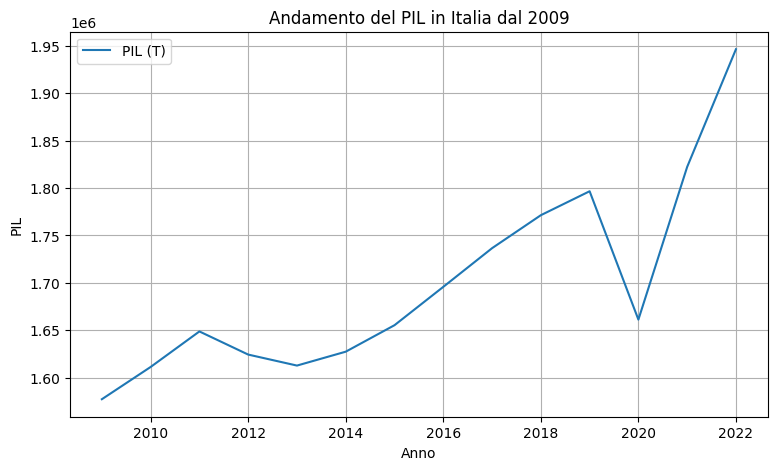

In [69]:
# Creazione del grafico che mostra l'andamento del PIL in italia dal 2009

anno_colonna = 'TIME'  
pil_colonna = 'Value'    

# Crea il grafico
plt.figure(figsize=(9, 5))
sns.lineplot(data=dati_completi_1, x=anno_colonna, y=pil_colonna, label='PIL (T)')
plt.title('Andamento del PIL in Italia dal 2009')
plt.xlabel('Anno')
plt.ylabel(f'PIL')
plt.grid(True)

# Aggiungi una leggenda per l'unità di misura
plt.legend()
plt.show()

In [ ]:
# Conversione di un array in py, in un tensore
dati_completi_1 = dati_completi_1.fillna(0)
dati_completi_1 = dati_completi_1.select_dtypes(include=[np.number])
array = dati_completi_1.to_numpy()
tensor = torch.tensor(array, dtype=torch.int32)

# Stampa il tensore 
print(tensor)

tensor([[   2009, 1577255],
        [   2010, 1611279],
        [   2011, 1648755],
        [   2012, 1624358],
        [   2013, 1612751],
        [   2014, 1627405],
        [   2015, 1655355],
        [   2016, 1695786],
        [   2017, 1736592],
        [   2018, 1771391],
        [   2019, 1796648],
        [   2020, 1661239],
        [   2021, 1822344],
        [   2022, 1946479]], dtype=torch.int32)


In [ ]:
# Normalizzazione del tensore
tensor_min = tensor.min(dim=0, keepdim=True).values
tensor_max = tensor.max(dim=0, keepdim=True).values
tensor_normalized = (tensor - tensor_min) / (tensor_max - tensor_min)

seq_length = 3

# Funzione per creare le sequenze temporali
def create_sequences(tensor, seq_length):
    sequences = []
    targets = []
    for i in range(len(tensor) - seq_length):
        seq = tensor[i:i+seq_length, :]
        target = tensor[i+seq_length, 1] 
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.tensor(targets)

# Crea le sequenze e i target
sequences, targets = create_sequences(tensor_normalized, seq_length)

# Creazione del DataLoader
dataset = TensorDataset(sequences, targets)
batch_size = 1  # Scegli il batch size appropriato
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Definizione del modello LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Parametri del modello
input_size = sequences.shape[2]  # Numero di caratteristiche in ciascun passo temporale
hidden_size = 64
num_layers = 1
output_size = 1

# Crea un'istanza del modello
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
# Addestramento del modello
num_epochs = 100
for epoch in range(num_epochs):
    model.train() 
    epoch_loss = 0.0
    for batch_seq, batch_target in dataloader:
        optimizer.zero_grad()
        output = model(batch_seq)
        loss = criterion(output.squeeze(), batch_target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

num_predictions = 5
predicted_values = []

# Esempio di previsione
model.eval()  
with torch.no_grad():
    last_sequence = sequences[-1].unsqueeze(0)  
    predicted_value_normalized = model(last_sequence).item()
    predicted_value = predicted_value_normalized * (tensor_max[0, 1] - tensor_min[0, 1]) + tensor_min[0, 1] 

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0436
Epoch [20/100], Loss: 0.0281
Epoch [30/100], Loss: 0.0237
Epoch [40/100], Loss: 0.0229
Epoch [50/100], Loss: 0.0222
Epoch [60/100], Loss: 0.0216
Epoch [70/100], Loss: 0.0209
Epoch [80/100], Loss: 0.0201
Epoch [90/100], Loss: 0.0192
Epoch [100/100], Loss: 0.0182


In [ ]:

#Valutazione del codice
model.eval()  
with torch.no_grad():
    last_sequence = sequences[-1].unsqueeze(0)  
    for _ in range(num_predictions):
        predicted_value_normalized = model(last_sequence).item()
        predicted_value = predicted_value_normalized * (tensor_max[0, 1] - tensor_min[0, 1]) + tensor_min[0, 1]
        predicted_values.append(predicted_value)

        new_sequence = torch.cat((last_sequence[:, 1:, :], torch.tensor([[[tensor[-1, 0] + 1, predicted_value_normalized]]], dtype=torch.float32)), dim=1)
        last_sequence = new_sequence

# Stampa le previsioni
for i, value in enumerate(predicted_values, 1):
    print(f'Predicted value for year {int(tensor[-1, 0].item()) + i}: {value:.2f}')

Predicted value for year 2023: 1872119.38
Predicted value for year 2024: 2701166.75
Predicted value for year 2025: 2842571.50
Predicted value for year 2026: 2870810.50
Predicted value for year 2027: 2870766.25
